#### Importing

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np
import pandas as pd
from transformers import DataCollatorWithPadding

from datasets import load_dataset, DatasetDict, Dataset

ModuleNotFoundError: No module named 'evaluate'

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [7]:
from collections import Counter
import torch
from sklearn.utils.class_weight import compute_class_weight


ModuleNotFoundError: No module named 'sklearn'

#### DATASET

In [2]:

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from hf_data import emotions
from metrics import *

d:\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train = emotions('train')

d:\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\JIYA SINHA\.cache\huggingface\hub\datasets--dair-ai--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For 

In [5]:
train

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
label_counts = Counter(train['label'])
print(label_counts)

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})


In [9]:
labels = np.array(train['label'])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

print("Class weights:", class_weights)


NameError: name 'np' is not defined

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights,
                             dtype=torch.float).to(device)

In [33]:
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels),
                    labels.view(-1))
    return (loss, outputs) if return_outputs else loss

#### model

In [35]:
model_path = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)


In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels = 6, id2label=id2labels, label2id = labels2id,)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Setting trainable params

In [37]:
# TRAIN ALL PARAMS 

In [38]:
for name, param in model.named_parameters():
    param.requires_grad = True


#### Data Preprocessing

In [39]:
def preprocess(ex):
    return tokenizer(ex['text'], truncation=True)

token_data = ds.map(preprocess, batched=True)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 71005.65 examples/s]


In [40]:
token_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [41]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # we need to have same size example in a batch while training.

#### Evaluation metric

In [53]:
accuracy_metric = evaluate.load("accuracy")

In [54]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]}



#### Training

In [44]:
lr = 2e-5             
batch_size = 16         
num_epochs = 10       
weight_decay = 0.01     
warmup_ratio = 0.1      
max_length = 128       


In [45]:
training_args = TrainingArguments(
    output_dir="distilbert-finetune",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none",

)


In [57]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=token_data['train'],
    eval_dataset=token_data['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



/tmp/ipykernel_43592/3148696197.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [47]:
from transformers import TrainerCallback

class PrintMetricsCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"\nEpoch {int(state.epoch)} | Eval Loss: {metrics['eval_loss']:.4f} | Eval Accuracy: {metrics.get('eval_accuracy', 0):.4f}")

trainer.add_callback(PrintMetricsCallback)

In [48]:
trainer.train()
trainer.save_model("DISTILLbert/final_model")



Epoch,Training Loss,Validation Loss,Accuracy
1,0.433200,0.241661,0.916500
2,0.186700,0.192628,0.933500
3,0.133200,0.162420,0.939000
4,0.113400,0.176324,0.941500
5,0.080000,0.244709,0.932500
6,0.054600,0.251997,0.933000
7,0.037100,0.298292,0.937000
8,0.025300,0.326462,0.938500
9,0.022300,0.340754,0.935500
10,0.018100,0.335498,0.935500



Epoch 1 | Eval Loss: 0.2417 | Eval Accuracy: 0.9165

Epoch 2 | Eval Loss: 0.1926 | Eval Accuracy: 0.9335

Epoch 3 | Eval Loss: 0.1624 | Eval Accuracy: 0.9390

Epoch 4 | Eval Loss: 0.1763 | Eval Accuracy: 0.9415

Epoch 5 | Eval Loss: 0.2447 | Eval Accuracy: 0.9325

Epoch 6 | Eval Loss: 0.2520 | Eval Accuracy: 0.9330

Epoch 7 | Eval Loss: 0.2983 | Eval Accuracy: 0.9370

Epoch 8 | Eval Loss: 0.3265 | Eval Accuracy: 0.9385

Epoch 9 | Eval Loss: 0.3408 | Eval Accuracy: 0.9355

Epoch 10 | Eval Loss: 0.3355 | Eval Accuracy: 0.9355



Classification Report:
              precision    recall  f1-score   support

           0      0.979     0.957     0.968       581
           1      0.936     0.961     0.948       695
           2      0.871     0.761     0.812       159
           3      0.922     0.945     0.934       275
           4      0.891     0.879     0.885       224
           5      0.684     0.788     0.732        66

    accuracy                          0.927      2000
   macro avg      0.880     0.882     0.880      2000
weighted avg      0.928     0.927     0.927      2000



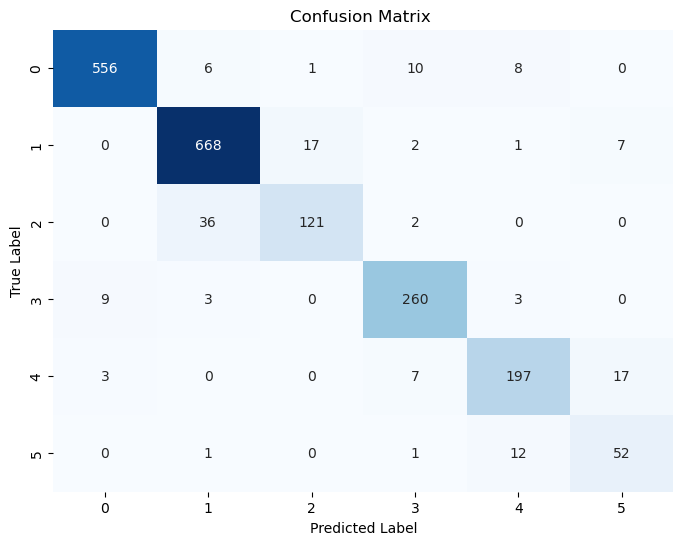

In [58]:
predictions = trainer.predict(token_data["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix ")
plt.show()
